In [59]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from typing import Dict, Any, Tuple, List

In [94]:
def detect_green_balls(
    rgb_img: np.ndarray,
    center_rgb: Tuple[int, int, int] = (0, 89, 92),  # your ball color
    h_tol: int = 10,          # +/- hue tolerance (OpenCV H in [0..179])
    s_min: int = 50,          # minimum saturation to avoid grays
    min_area: float = 50.0,   # contour area filter
    min_radius: int = 8,      # min radius in pixels
    circularity_thresh: float = 0.6
) -> Tuple[Dict[str, Any], np.ndarray]:
    """
    Detect teal/green balls using HS-only masking (brightness ignored).

    Parameters
    ----------
    rgb_img : np.ndarray
        RGB image (H,W,3), dtype uint8.
    center_rgb : tuple
        Reference RGB color used to compute target hue (e.g., your ball color).
    h_tol : int
        +/- tolerance around the target hue (OpenCV hue in [0..179]).
    s_min : int
        Minimum saturation threshold (0..255).
    min_area : float
        Minimum contour area (pixels^2).
    min_radius : int
        Minimum enclosing circle radius (pixels).
    circularity_thresh : float
        0..1, higher = more circular.

    Returns
    -------
    points : dict with fields:
        - "count": number of detected balls
        - "balls": list of dicts with keys:
            "center" (x,y), "radius", "area", "circularity", "bbox" (x,y,w,h)
    vis_img : np.ndarray
        BGR visualization image with contours, circles, and labels.
    """
    if rgb_img is None or rgb_img.ndim != 3 or rgb_img.shape[2] != 3:
        raise ValueError("rgb_img must be an RGB image with shape (H, W, 3).")

    # --- derive target hue from the provided RGB color
    ref_rgb = np.uint8([[[center_rgb[0], center_rgb[1], center_rgb[2]]]])
    ref_hsv = cv2.cvtColor(ref_rgb, cv2.COLOR_RGB2HSV)[0, 0]
    h0 = int(ref_hsv[0])  # OpenCV H in [0..179]

    # --- convert image to HSV
    bgr = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    H = hsv[:, :, 0]
    S = hsv[:, :, 1]
    # V = hsv[:, :, 2]  # intentionally ignored

    # --- build HS-only mask with hue wrap-around
    lower = (h0 - h_tol) % 180
    upper = (h0 + h_tol) % 180
    if lower <= upper:
        hue_mask = (H >= lower) & (H <= upper)
    else:
        hue_mask = (H >= lower) | (H <= upper)
    sat_mask = (S >= s_min)
    mask = (hue_mask & sat_mask).astype(np.uint8) * 255

    # --- clean up mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # --- find contours
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    vis = rgb_img.copy()
    balls: List[Dict[str, Any]] = []

    for c in cnts:
        area = float(cv2.contourArea(c))
        if area < min_area:
            continue

        (cx, cy), r = cv2.minEnclosingCircle(c)
        cx, cy, r = int(round(cx)), int(round(cy)), int(round(r))
        if r < min_radius:
            continue

        perimeter = cv2.arcLength(c, True)
        if perimeter <= 0:
            continue
        circularity = float(4.0 * np.pi * (area / (perimeter * perimeter)))
        if circularity < circularity_thresh:
            continue

        x, y, w, h = cv2.boundingRect(c)

        balls.append({
            "center": (cx, cy),
            "radius": int(r),
            "area": area,  # <-- area included
            "circularity": circularity,
            "bbox": (int(x), int(y), int(w), int(h)),
        })

        # visualization
        cv2.circle(vis, (cx, cy), r, (0, 255, 0), 2)
        cv2.circle(vis, (cx, cy), 3, (255, 0, 0), -1)
        cv2.drawContours(vis, [c], -1, (255, 0, 0), 2)
        label = f"r={r}px, A={int(area)}"
        org = (max(0, cx - r), max(15, cy - r - 5))
        cv2.putText(vis, label, org, cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (10, 10, 10), 3, cv2.LINE_AA)
        cv2.putText(vis, label, org, cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 255), 1, cv2.LINE_AA)

    points = {"count": len(balls), "balls": balls}
    return points, vis  # vis is BGR; convert to RGB if you need

In [95]:
!pwd

/d/TU Courses/Pi Competitive Robot/picr25-team-1_9-tdi-software/software/notebooks


In [67]:
# Link to download images: https://drive.google.com/drive/folders/1XE7l2gMPB1oobV3QWQtXLQd2IRg0kGSH?usp=sharing 
IM_DIR = "../../../images/boundary_segmentation"

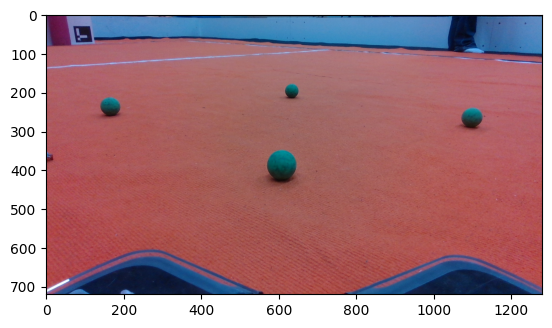

In [68]:
input_im_bgr = cv2.imread(os.path.join(IM_DIR, "rgb_817512071221_20250915_201507_476186.png"))
input_im_rgb = cv2.cvtColor(input_im_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(input_im_rgb)

In [45]:
# Intrinsic parameters (MATLAB)
K = np.array([
    [803.938356905409,   0.0,               645.705518859391],
    [0.0,               696.727389723765,  503.716447214066],
    [0.0,                 0.0,               1.0]
])

# Tcw = np.array([
#     [-0.999677991415228,  0.0213459846717834, -0.0137208752784682, 146.417166794883],
#     [-0.0167458522988459, -0.148696173875208,  0.988741131088244, 181.342805912862],
#     [ 0.0190654113724443,  0.988652515706740,  0.149005749137185, 413.997745946141],
#     [0.0,                 0.0,                 0.0,                 1.0]
# ])

Tcw = np.array([
    [-0.999445053514234,  0.0311668140034160, -0.0117564752713937, 151.709101137451],
    [-0.0272618931789373, -0.562521368709480,  0.826333164604636,  15.6591502297979],
    [ 0.0191409034852234,  0.826195097691876,  0.563058865806836, 351.145139703044],
    [0.0,                 0.0,                 0.0,                 1.0]
])

rad_dist = np.array([0.0909766695559124, -0.134088918633949])
tan_dist = np.array([0,0])
distCoeffs = np.array([rad_dist[0], rad_dist[1], tan_dist[0], tan_dist[1], 0])

H = K @ Tcw[:3, [0,1,3]]
H

array([[-7.91132827e+02,  5.58534931e+02,  3.48701120e+05],
       [-9.35251977e+00,  2.42440144e+01,  1.87787741e+05],
       [ 1.91409035e-02,  8.26195098e-01,  3.51145140e+02]])

In [46]:
# Validate H matrix
im_point = np.array([600, 400, 1])
wd_point = np.linalg.pinv(H) @ im_point.reshape(-1,1)
wd_point = (wd_point/wd_point[-1]).ravel()
wd_point

array([183.25470069, 144.37562199,   1.        ])

In [47]:
"Distance w -> cam", np.linalg.norm(Tcw[:3,3])

('Distance w -> cam', np.float64(382.8364787881675))

In [48]:
twc = -Tcw[:3,:3].T @ Tcw[:3,3]
twc

array([ 145.33057356, -286.03407572, -208.87149496])

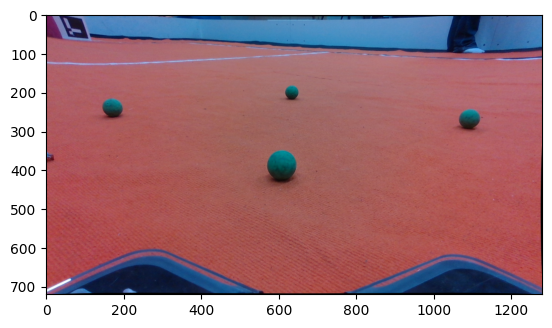

In [69]:
# --- Undistort (simple way) ---
undistorted = cv2.undistort(input_im_rgb, K, distCoeffs)
plt.imshow(undistorted)

## Transform: robot base frame (B) w.r.t. camera (C)

In [50]:
def fix_rotation_svd(R):
    """
    Project a near-rotation matrix R (3x3) to the closest proper rotation in SO(3).
    """
    U, S, Vt = np.linalg.svd(R)
    R_hat = U @ Vt
    # Enforce det = +1 (avoid reflections)
    if np.linalg.det(R_hat) < 0:
        U[:, -1] *= -1
        R_hat = U @ Vt
    return R_hat

In [51]:
# handle rotation (Rbc)
Xb = np.array([1,0,0])/np.linalg.norm(np.array([1,0,0]))
Zb = -Tcw[:3,2]/np.linalg.norm(Tcw[:3,2])
Yb = np.cross(Zb, Xb)/np.linalg.norm(np.cross(Zb, Xb))
Rcb = np.hstack([Xb.reshape(3,1), Yb.reshape(3,1), Zb.reshape(3,1)])
Rbc = Rcb.T
print("Rbc: \n", fix_rotation_svd(Rbc))

# handle translation (tbc)
tbc = np.array([0, -50, -twc[-1]])

Tbc = np.hstack([Rbc, tbc.reshape(3,1)])
Tbc = np.vstack([Tbc, [0, 0, 0, 1]])
print("Tbc: \n", Tbc)

Rbc: 
 [[ 9.99982722e-01  4.85780235e-03  3.31007976e-03]
 [ 9.22953605e-19 -5.63097781e-01  8.26390276e-01]
 [ 5.87833920e-03 -8.26375998e-01 -5.63088052e-01]]
Tbc: 
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -5.63097781e-01  8.26390276e-01 -5.00000000e+01]
 [ 1.17564753e-02 -8.26333165e-01 -5.63058866e-01  2.08871495e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [52]:
Tbw = Tbc @ Tcw
print("Tbw: \n", Tbw)

Tbw: 
 [[-9.99445054e-01  3.11668140e-02 -1.17564753e-02  1.51709101e+02]
 [ 3.11689681e-02  9.99514130e-01 -1.60270640e-18  2.31365296e+02]
 [-4.45704372e-17 -6.20777250e-16 -1.00000000e+00 -5.68434189e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Validate transformation matrices

In [53]:
im_point = np.array([600, 400, 1])
wd_point = np.linalg.pinv(H) @ im_point.reshape(-1,1)
wd_point = (wd_point/wd_point[-1]).ravel()
wd_point

array([183.25470069, 144.37562199,   1.        ])

In [58]:
b_point = Tbw @ np.array([wd_point[0], wd_point[1], 0, 1]).reshape(4,1)
b_point = b_point/b_point[3]
print("Ball location in robot_base frame:", np.round(b_point[:,:3].ravel()/10, 3)[:3], "cm")

Ball location in robot_base frame: [-2.694 38.138 -0.   ] cm


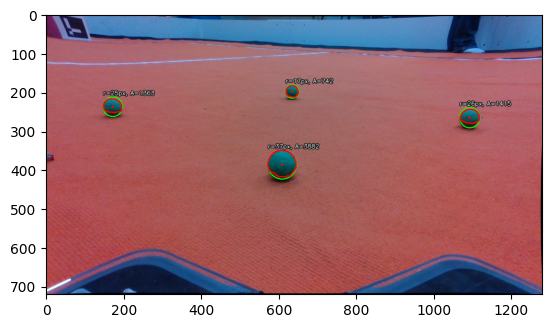

In [96]:
points_dict, viz = detect_green_balls(undistorted, center_rgb=(0, 89, 92), h_tol=30, s_min=50, min_area=40, min_radius=8, circularity_thresh=0.6)
plt.imshow(viz)

In [93]:
points_dict

{'count': 4,
 'balls': [{'center': (609, 387),
   'radius': 37,
   'area': 3882.0,
   'circularity': 0.8082047655587563,
   'bbox': (572, 350, 74, 69)},
  {'center': (1093, 266),
   'radius': 26,
   'area': 1415.5,
   'circularity': 0.8122645947292867,
   'bbox': (1068, 245, 51, 37)},
  {'center': (172, 238),
   'radius': 25,
   'area': 1363.5,
   'circularity': 0.8186792203462407,
   'bbox': (148, 218, 48, 36)},
  {'center': (635, 199),
   'radius': 17,
   'area': 742.0,
   'circularity': 0.8361853544941746,
   'bbox': (619, 184, 33, 30)}]}

In [111]:
for ball in points_dict["balls"]:
    ball_pos = np.array(ball["center"])
    ball_pos_h = np.hstack([ball_pos, 1]).reshape(-1,1)
    # convert image points to world frame
    wd_point = np.linalg.pinv(H) @ ball_pos_h
    wd_point = (wd_point/wd_point[-1]).ravel()
    # convert to base-frame 
    b_point = Tbw @ np.array([wd_point[0], wd_point[1], 0, 1]).reshape(4,1)
    b_point = b_point/b_point[3]
    b_point_xy = np.round(b_point[:,:3].ravel()/10, 3)[:2]
    print(f"Ball location in: image frame ({ball_pos}) pixels, robot_base frame (x={b_point_xy[0]}, y={b_point_xy[1]}) cm")

Ball location in: image frame ([609 387]) pixels, robot_base frame (x=-2.243, y=40.232) cm
Ball location in: image frame ([1093  266]) pixels, robot_base frame (x=42.323, y=72.477) cm
Ball location in: image frame ([172 238]) pixels, robot_base frame (x=-48.294, y=80.334) cm
Ball location in: image frame ([635 199]) pixels, robot_base frame (x=-1.378, y=106.017) cm


In [113]:
cv2.imwrite("viz.png", cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

True